In [1]:
import csv
import numpy as np
import urllib2
import StringIO
import pickle


In [2]:
from matplotlib.transforms import Bbox, TransformedBbox, \
     blended_transform_factory
from mpl_toolkits.axes_grid1.inset_locator import BboxPatch, BboxConnector,\
     BboxConnectorPatch
import matplotlib.pyplot as plt

In [3]:
from netCDF4 import Dataset

In [2]:
import datetime as dt  # Python standard library datetime  module
import numpy as np
from netCDF4 import Dataset  # http://code.google.com/p/netcdf4-python/
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, addcyclic, shiftgrid

NetCDF Global Attributes:
	Conventions: u'COARDS'
	title: u'mean daily NMC reanalysis (2012)'
	history: u'created 2011/12 by Hoop (netCDF2.3)'
	description: u'Data is from NMC initialized reanalysis\n(4x/day).  These are the 0.9950 sigma level values.'
	platform: u'Model'
	references: u'http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis.html'
NetCDF dimension information:
	Name: lat
		size: 73
		type: dtype('float32')
		units: u'degrees_north'
		actual_range: array([ 90., -90.], dtype=float32)
		long_name: u'Latitude'
		standard_name: u'latitude'
		axis: u'Y'
	Name: lon
		size: 144
		type: dtype('float32')
		units: u'degrees_east'
		long_name: u'Longitude'
		actual_range: array([   0. ,  357.5], dtype=float32)
		standard_name: u'longitude'
		axis: u'X'
	Name: time
		size: 366
		type: dtype('float64')
		units: u'hours since 1-1-1 00:00:0.0'
		long_name: u'Time'
		actual_range: array([ 17628096.,  17636856.])
		delta_t: u'0000-00-01 00:00:00'
		standard_name: u'time'
		axis: 

C:\Anaconda\lib\site-packages\mpl_toolkits\basemap\__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
C:\Anaconda\lib\site-packages\mpl_toolkits\basemap\__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
C:\Anaconda\lib\site-packages\mpl_toolkits\basemap\__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


NetCDF variable information:
	Name: air
		dimensions: (u'time', u'lat', u'lon')
		size: 3847392
		type: dtype('int16')
		long_name: u'mean Daily Air temperature at sigma level 995'
		unpacked_valid_range: array([ 185.16000366,  331.16000366], dtype=float32)
		actual_range: array([ 193.80001831,  317.52001953], dtype=float32)
		units: u'degK'
		add_offset: 512.81
		scale_factor: 0.0099999998
		missing_value: 32766
		precision: 2
		least_significant_digit: 1
		GRIB_id: 11
		GRIB_name: u'TMP'
		var_desc: u'Air temperature'
		dataset: u'NCEP Reanalysis Daily Averages'
		level_desc: u'Surface'
		statistic: u'Mean\nM'
		parent_stat: u'Individual Obs\nI'
		valid_range: array([-32765, -18165], dtype=int16)


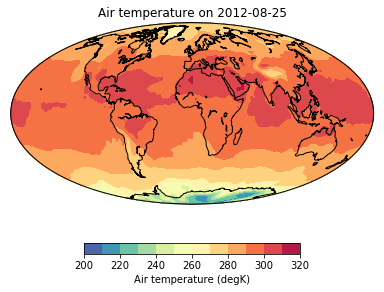

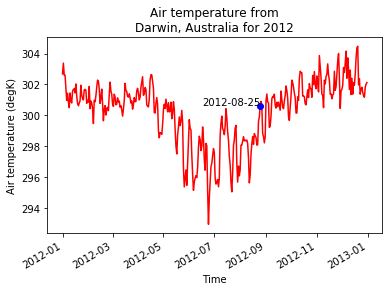

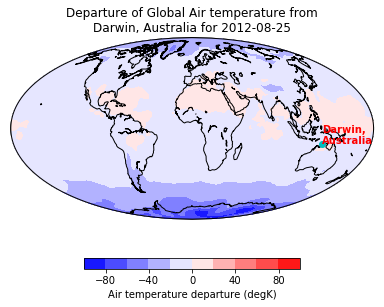

In [8]:
def ncdump(nc_fid, verb=True):
    '''
    ncdump outputs dimensions, variables and their attribute information.
    The information is similar to that of NCAR's ncdump utility.
    ncdump requires a valid instance of Dataset.

    Parameters
    ----------
    nc_fid : netCDF4.Dataset
        A netCDF4 dateset object
    verb : Boolean
        whether or not nc_attrs, nc_dims, and nc_vars are printed

    Returns
    -------
    nc_attrs : list
        A Python list of the NetCDF file global attributes
    nc_dims : list
        A Python list of the NetCDF file dimensions
    nc_vars : list
        A Python list of the NetCDF file variables
    '''
    def print_ncattr(key):
        """
        Prints the NetCDF file attributes for a given key

        Parameters
        ----------
        key : unicode
            a valid netCDF4.Dataset.variables key
        """
        try:
            print "\t\ttype:", repr(nc_fid.variables[key].dtype)
            for ncattr in nc_fid.variables[key].ncattrs():
                print '\t\t%s:' % ncattr,\
                      repr(nc_fid.variables[key].getncattr(ncattr))
        except KeyError:
            print "\t\tWARNING: %s does not contain variable attributes" % key

    # NetCDF global attributes
    nc_attrs = nc_fid.ncattrs()
    if verb:
        print "NetCDF Global Attributes:"
        for nc_attr in nc_attrs:
            print '\t%s:' % nc_attr, repr(nc_fid.getncattr(nc_attr))
    nc_dims = [dim for dim in nc_fid.dimensions]  # list of nc dimensions
    # Dimension shape information.
    if verb:
        print "NetCDF dimension information:"
        for dim in nc_dims:
            print "\tName:", dim 
            print "\t\tsize:", len(nc_fid.dimensions[dim])
            print_ncattr(dim)
    # Variable information.
    nc_vars = [var for var in nc_fid.variables]  # list of nc variables
    if verb:
        print "NetCDF variable information:"
        for var in nc_vars:
            if var not in nc_dims:
                print '\tName:', var
                print "\t\tdimensions:", nc_fid.variables[var].dimensions
                print "\t\tsize:", nc_fid.variables[var].size
                print_ncattr(var)
    return nc_attrs, nc_dims, nc_vars

nc_f = 'air.sig995.2012.nc'  # Your filename
nc_fid = Dataset(nc_f, 'r')  # Dataset is the class behavior to open the file
                             # and create an instance of the ncCDF4 class
nc_attrs, nc_dims, nc_vars = ncdump(nc_fid)
# Extract data from NetCDF file
lats = nc_fid.variables['lat'][:]  # extract/copy the data
lons = nc_fid.variables['lon'][:]
time = nc_fid.variables['time'][:]
air = nc_fid.variables['air'][:]  # shape is time, lat, lon as shown above

time_idx = 237  # some random day in 2012
# Python and the renalaysis are slightly off in time so this fixes that problem
offset = dt.timedelta(hours=48)
# List of all times in the file as datetime objects
dt_time = [dt.date(1, 1, 1) + dt.timedelta(hours=t) - offset\
           for t in time]
cur_time = dt_time[time_idx]

# Plot of global temperature on our random day
fig = plt.figure()
fig.subplots_adjust(left=0., right=1., bottom=0., top=0.9)
# Setup the map. See http://matplotlib.org/basemap/users/mapsetup.html
# for other projections.
m = Basemap(projection='moll', llcrnrlat=-90, urcrnrlat=90,\
            llcrnrlon=0, urcrnrlon=360, resolution='c', lon_0=0)
m.drawcoastlines()
m.drawmapboundary()
# Make the plot continuous
air_cyclic, lons_cyclic = addcyclic(air[time_idx, :, :], lons)
# Shift the grid so lons go from -180 to 180 instead of 0 to 360.
air_cyclic, lons_cyclic = shiftgrid(180., air_cyclic, lons_cyclic, start=False)
# Create 2D lat/lon arrays for Basemap
lon2d, lat2d = np.meshgrid(lons_cyclic, lats)
# Transforms lat/lon into plotting coordinates for projection
x, y = m(lon2d, lat2d)
# Plot of air temperature with 11 contour intervals
cs = m.contourf(x, y, air_cyclic, 11, cmap=plt.cm.Spectral_r)
cbar = plt.colorbar(cs, orientation='horizontal', shrink=0.5)
cbar.set_label("%s (%s)" % (nc_fid.variables['air'].var_desc,\
                            nc_fid.variables['air'].units))
plt.title("%s on %s" % (nc_fid.variables['air'].var_desc, cur_time))

# Writing NetCDF files
# For this example, we will create two NetCDF4 files. One with the global air
# temperature departure from its value at Darwin, Australia. The other with
# the temperature profile for the entire year at Darwin.
darwin = {'name': 'Darwin, Australia', 'lat': -12.45, 'lon': 130.83}

# Find the nearest latitude and longitude for Darwin
lat_idx = np.abs(lats - darwin['lat']).argmin()
lon_idx = np.abs(lons - darwin['lon']).argmin()

# Simple example: temperature profile for the entire year at Darwin.
# Open a new NetCDF file to write the data to. For format, you can choose from
# 'NETCDF3_CLASSIC', 'NETCDF3_64BIT', 'NETCDF4_CLASSIC', and 'NETCDF4'
w_nc_fid = Dataset('darwin_2012.nc', 'w', format='NETCDF4')
w_nc_fid.description = "NCEP/NCAR Reanalysis %s from its value at %s. %s" %\
                      (nc_fid.variables['air'].var_desc.lower(),\
                       darwin['name'], nc_fid.description)
# Using our previous dimension info, we can create the new time dimension
# Even though we know the size, we are going to set the size to unknown
w_nc_fid.createDimension('time', None)
w_nc_dim = w_nc_fid.createVariable('time', nc_fid.variables['time'].dtype,\
                                   ('time',))
# You can do this step yourself but someone else did the work for us.
for ncattr in nc_fid.variables['time'].ncattrs():
    w_nc_dim.setncattr(ncattr, nc_fid.variables['time'].getncattr(ncattr))
# Assign the dimension data to the new NetCDF file.
w_nc_fid.variables['time'][:] = time
w_nc_var = w_nc_fid.createVariable('air', 'f8', ('time'))
w_nc_var.setncatts({'long_name': u"mean Daily Air temperature",\
                    'units': u"degK", 'level_desc': u'Surface',\
                    'var_desc': u"Air temperature",\
                    'statistic': u'Mean\nM'})
w_nc_fid.variables['air'][:] = air[time_idx, lat_idx, lon_idx]
w_nc_fid.close()  # close the new file

# A plot of the temperature profile for Darwin in 2012
fig = plt.figure()
plt.plot(dt_time, air[:, lat_idx, lon_idx], c='r')
plt.plot(dt_time[time_idx], air[time_idx, lat_idx, lon_idx], c='b', marker='o')
plt.text(dt_time[time_idx], air[time_idx, lat_idx, lon_idx], cur_time,\
         ha='right')
fig.autofmt_xdate()
plt.ylabel("%s (%s)" % (nc_fid.variables['air'].var_desc,\
                        nc_fid.variables['air'].units))
plt.xlabel("Time")
plt.title("%s from\n%s for %s" % (nc_fid.variables['air'].var_desc,\
                                  darwin['name'], cur_time.year))

# Complex example: global temperature departure from its value at Darwin
departure = air[:, :, :] - air[:, lat_idx, lon_idx].reshape((time.shape[0],\
                                                             1, 1))

# Open a new NetCDF file to write the data to. For format, you can choose from
# 'NETCDF3_CLASSIC', 'NETCDF3_64BIT', 'NETCDF4_CLASSIC', and 'NETCDF4'
w_nc_fid = Dataset('air.departure.sig995.2012.nc', 'w', format='NETCDF4')
w_nc_fid.description = "The departure of the NCEP/NCAR Reanalysis " +\
                      "%s from its value at %s. %s" %\
                      (nc_fid.variables['air'].var_desc.lower(),\
                       darwin['name'], nc_fid.description)
# Using our previous dimension information, we can create the new dimensions
data = {}
for dim in nc_dims:
    w_nc_fid.createDimension(dim, nc_fid.variables[dim].size)
    data[dim] = w_nc_fid.createVariable(dim, nc_fid.variables[dim].dtype,\
                                        (dim,))
    # You can do this step yourself but someone else did the work for us.
    for ncattr in nc_fid.variables[dim].ncattrs():
        data[dim].setncattr(ncattr, nc_fid.variables[dim].getncattr(ncattr))
# Assign the dimension data to the new NetCDF file.
w_nc_fid.variables['time'][:] = time
w_nc_fid.variables['lat'][:] = lats
w_nc_fid.variables['lon'][:] = lons

# Ok, time to create our departure variable
w_nc_var = w_nc_fid.createVariable('air_dep', 'f8', ('time', 'lat', 'lon'))
w_nc_var.setncatts({'long_name': u"mean Daily Air temperature departure",\
                    'units': u"degK", 'level_desc': u'Surface',\
                    'var_desc': u"Air temperature departure",\
                    'statistic': u'Mean\nM'})
w_nc_fid.variables['air_dep'][:] = departure
w_nc_fid.close()  # close the new file

# Rounded maximum absolute value of the departure used for contouring
max_dep = np.round(np.abs(departure[time_idx, :, :]).max()+5., decimals=-1)

# Generate a figure of the departure for a single day
fig = plt.figure()
fig.subplots_adjust(left=0., right=1., bottom=0., top=0.9)
m = Basemap(projection='moll', llcrnrlat=-90, urcrnrlat=90,\
            llcrnrlon=0, urcrnrlon=360, resolution='c', lon_0=0)
m.drawcoastlines()
m.drawmapboundary()
dep_cyclic, lons_cyclic = addcyclic(departure[time_idx, :, :], lons)
dep_cyclic, lons_cyclic = shiftgrid(180., dep_cyclic, lons_cyclic, start=False)
lon2d, lat2d = np.meshgrid(lons_cyclic, lats)
x, y = m(lon2d, lat2d)
levels = np.linspace(-max_dep, max_dep, 11)
cs = m.contourf(x, y, dep_cyclic, levels=levels, cmap=plt.cm.bwr)
x, y = m(darwin['lon'], darwin['lat'])
plt.plot(x, y, c='c', marker='o')
plt.text(x, y, 'Darwin,\nAustralia', color='r', weight='semibold')
cbar = plt.colorbar(cs, orientation='horizontal', shrink=0.5)
cbar.set_label("%s departure (%s)" % (nc_fid.variables['air'].var_desc,\
                            nc_fid.variables['air'].units))
plt.title("Departure of Global %s from\n%s for %s" %\
          (nc_fid.variables['air'].var_desc, darwin['name'], cur_time))
plt.show()

In [4]:
from netCDF4 import Dataset

In [5]:
rootgrp = Dataset("BD_2051-2100_tasmax_rcp85_NorESM1-M.nc", "w", format="NETCDF4")

In [11]:
rootgrp

<type 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): 
    variables(dimensions): 
    groups: 

In [12]:
print rootgrp.data_model

NETCDF4


In [13]:
df=Dataset("E1_north_america.nc")
df

<type 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.5
    dimensions(sizes): time(240), latitude(37), longitude(49), bnds(2)
    variables(dimensions): float32 air_temperature(time,latitude,longitude), int32 latitude_longitude(), float64 time(time), float64 time_bnds(time,bnds), float32 latitude(latitude), float32 longitude(longitude), int32 forecast_period(time), float64 forecast_reference_time(), float64 height()
    groups: 

In [14]:
print df.dimensions

OrderedDict([(u'time', <type 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 240
), (u'latitude', <type 'netCDF4._netCDF4.Dimension'>: name = 'latitude', size = 37
), (u'longitude', <type 'netCDF4._netCDF4.Dimension'>: name = 'longitude', size = 49
), (u'bnds', <type 'netCDF4._netCDF4.Dimension'>: name = 'bnds', size = 2
)])


In [1]:
from netCDF4 import Dataset

In [10]:
nc1=Dataset('atlantic_profiles.nc')
nc1

<type 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.5
    dimensions(sizes): depth(40), lat(6), lon(8)
    variables(dimensions): float32 salinity(depth,lat,lon), float32 depth(depth), float32 lat(lat), float32 lon(lon), float64 time(), float32 theta(depth,lat,lon)
    groups: 

In [11]:
nc1

<type 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.5
    dimensions(sizes): depth(40), lat(6), lon(8)
    variables(dimensions): float32 salinity(depth,lat,lon), float32 depth(depth), float32 lat(lat), float32 lon(lon), float64 time(), float32 theta(depth,lat,lon)
    groups: 

In [13]:
nc2=Dataset('salt2017.nc')
nc2

<type 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    creation_date: Tue Dec 27 13:40:28 MST 2016
    sfcHeatFlux: 
Note that the net surface heat flux are the total surface heat flux 
from the NCEP reanalysis 2 plus the relaxation terms.
    time_comment: The internal time stamp indicates the FIRST day of the averaging period.
    Conventions: COARDS
    grib_file: godas.M.2017*
    html_REFERENCES: http://www.cpc.ncep.noaa.gov/products/GODAS/background.shtml
    html_BACKGROUND: http://www.cpc.ncep.noaa.gov/products/GODAS/background.shtml
    html_GODAS: www.cpc.ncep.noaa.gov/products/GODAS
    comment: NOTE:  THESE ARE THE BIAS CORRECTED GODAS FILES.
    title: GODAS: Global Ocean Data Assimilation System
    history: Created 2016/12 by Hoop
    References: http://www.esrl.noaa.gov/psd/data/gridded/data.godas.html
    dataset_title: NCEP Global Ocean Data Assimilation System (GODAS)
    dimensions(sizes): time(9), level(40), lat(418), lo

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [23]:
import urllib3

In [25]:
http=urllib3.PoolManager()
r= http.request('ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt','stations.txt')

In [26]:
r

In [29]:
open('stations.txt','r').readlines()[:10]

['ACW00011604  17.1167  -61.7833   10.1    ST JOHNS COOLIDGE FLD                       \n',
 'ACW00011647  17.1333  -61.7833   19.2    ST JOHNS                                    \n',
 'AE000041196  25.3330   55.5170   34.0    SHARJAH INTER. AIRP            GSN     41196\n',
 'AEM00041194  25.2550   55.3640   10.4    DUBAI INTL                             41194\n',
 'AEM00041217  24.4330   54.6510   26.8    ABU DHABI INTL                         41217\n',
 'AEM00041218  24.2620   55.6090  264.9    AL AIN INTL                            41218\n',
 'AF000040930  35.3170   69.0170 3366.0    NORTH-SALANG                   GSN     40930\n',
 'AFM00040938  34.2100   62.2280  977.2    HERAT                                  40938\n',
 'AFM00040948  34.5660   69.2120 1791.3    KABUL INTL                             40948\n',
 'AFM00040990  31.5000   65.8500 1010.0    KANDAHAR AIRPORT                       40990\n']

In [2]:
def cel_to_kelvin(cel):
    kelvin=cel+273
    return kelvin

In [6]:
cel_to_kelvin(-273)

0

In [7]:
def cel_to_farent(cel):
    farent=(cel*1.8)+32
    return farent

In [8]:
cel_to_farent(35)

95.0

In [34]:
import seawater as sw

In [35]:
from seawater.library import T90conv

In [38]:
s = [20, 23, 24, 25, 28, 30, 34, 35]
t = T90conv([23, 23, 30, 30, 28, 29, 30, 36])
p = [9.86923, 9.86923, 9.86923, 9.86923, 9.86923, 9.86923, 9.86923, 9.86923]
sw.dens(s, t, p)

array([ 1012.64479376,  1014.90533938,  1013.54920133,  1014.29473198,
        1017.18557658,  1018.35992629,  1021.02133402,  1019.59616958])

In [41]:
sigma=sw.pden(s, t, p, 4000) - 1000

In [42]:
sigma

array([ 29.31514622,  31.50560803,  29.7685387 ,  30.49307954,
        33.41286892,  34.49861579,  37.03340179,  35.36051256])

In [43]:
s = [0, 0, 0, 0, 35, 35, 35, 35]
t = T90conv([0, 0, 30, 30, 0, 0, 30, 30])
sw.dens0(s, t)

array([  999.842594  ,   999.842594  ,   995.65113374,   995.65113374,
        1028.10633141,  1028.10633141,  1021.72863949,  1021.72863949])

In [46]:
''' ref: Fofonoff, P. and Millard, R.C. Jr UNESCO 1983. Algorithms for computation of fundamental properties of seawater.
UNESCO Tech. Pap. in Mar. Sci., No. 44, 53 pp. Eqn.(31) p.39. 
http://unesdoc.unesco.org/images/0005/000598/059832eb.pdf
Millero, F.J., Chen, C.T., Bradshaw, A., and Schleicher, K. A new high pressure equation of state for seawater. Deap-Sea Research., 1980, 
Vol27A, pp255-264. doi:10.1016/0198-0149(80)90016-3
'''
sigma_t=sw.pden(s, t, 4000) - 1000
sigma_t

array([ -0.16070099,  -0.16070099,  -4.07027868,  -4.07027868,
        28.12084413,  28.12084413,  22.07173961,  22.07173961])

In [156]:
def temp_and_salinity_to_density(t,s):
    d=((999.8+6.7*t+6.79*0.1*t-9.0952*0.001*t**2)+(1.00168*0.0001*t**3)-(1.120083*0.000001*t**4)+(6.536332*0.000000001*t**5))
    d1=((8.2*0.1-4.08*0.001*t+7.6*0.00001*t**2)-(8.2*0.0000001*t**3)+(5.3*0.000000001*t**4))*s+d
    d2=((-5.72466*0.001+1.0227*0.0001*t)-(1.6546*0.000001*t**2)*s**1.5)+d1
    d3=((4.8314*0.0001)*s**2)+d2
        
    return d3
    print(temp_and_salinity_to_density(20,30))

In [157]:
#a=kg/m*3
a=temp_and_salinity_to_density(15,31.5)

In [158]:
A=(a-1)*1000

In [159]:
A

1132496.4194760066

In [143]:
def temp_and_salinity_to_density(t,s):
    d=((999.8+6.7*t+6.79*0.1*t-9.0952*0.001*t**2)+(1.00168*0.0001*t**3)-(1.120083*0.000001*t**4)+(6.536332*0.000000001*t**5))
    d1=((8.2*0.1-4.08*0.001*t+7.6*0.00001*t**2)-(8.2*0.0000001*t**3)+(5.3*0.000000001*t**4))*s+d
    d2=((-5.72466*0.001+1.0227*0.0001*t)-(1.6546*0.000001*t**2)*s**1.5)+d1
    d3=((4.8314*0.0001)*s**2)+d2
   
    return d3
print(temp_and_salinity_to_density(20,30))

1167.60000231


In [147]:
def temp_and_salinity_to_density(t,s):
    d=((999.8+6.7*t+6.79*0.1*t-9.0952*0.001*t**2)+(1.00168*0.0001*t**3)-(1.120083*0.000001*t**4)+(6.536332*0.000000001*t**5))
    d1=((8.2*0.1-4.08*0.001*t+7.6*0.00001*t**2)-(8.2*0.0000001*t**3)+(5.3*0.000000001*t**4))*s+d
    d2=((-5.72466*0.001+1.0227*0.0001*t)-(1.6546*0.000001*t**2)*s**1.5)+d1
    d3=((4.8314*0.0001)*s**2)+d2
   
    return d3

In [154]:
print(temp_and_salinity_to_density(15,31.5))

1133.49641948


In [6]:
from pydap.client import open_url

In [10]:
URL = 'http://nomads.ncep.noaa.gov:9090/dods/cmcens/cmcens20171030/cmcens_all_00z'
dataset = open_url(URL)
print type(dataset)

<class 'pydap.model.DatasetType'>


In [11]:
print dataset.keys()

['hgtprs', 'apcpsfc', 'capesfc', 'cinsfc', 'lhtflsfc', 'pressfc', 'prmslmsl', 'pwatl200', 'rhprs', 'rh2m', 'shtflsfc', 'snodsfc', 'tcdcl200', 'tmax2m', 'tmin2m', 'tmpprs', 'tmp2m', 'tmp0_10cm', 'ugrdprs', 'ugrd10m', 'vgrdprs', 'vgrd10m', 'vvel850mb', 'weasdsfc', 'ens', 'time', 'lev', 'lat', 'lon']


In [12]:
temp = dataset['tmp0_10cm']

In [13]:
print temp.dimensions

('ens', 'time', 'lat', 'lon')


In [4]:
import csv

In [5]:
f=open('obis_seamap_species_180530_points_csv.csv','r')

In [6]:
r=csv.DictReader(f)

In [7]:
lat,lon,num=[],[],[]

In [14]:
errors=0
for row in r:
    try:
        lat.append(float(row['latitude']))
        lon.append(float(row['longitude']))
        if not row['count']=='':
            num.append(float(row['count']))
        else:
            num.append(1)
    except ValueError:
        errors = errors + 1 
       

In [9]:
errors = 0
for row in r:
    try: # The "Try/except" routine, prevents the loop to break if there is an empty field
        lat.append(float(row['latitude']))
        lon.append(float(row['longitude']))
        if not row['count'] == '':
            num.append(float(row['count']))
        else:
            num.append(1) # If "count" is empty, replace it with a 1
    except ValueError:
        errors = errors + 1 

In [20]:
m1 = Basemap(projection='mill',llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=-180,urcrnrlon=180,resolution='c')

In [25]:
x,y=m1(lon,lat)

In [26]:
nbins=200
H,xedges,yedges=np.histogram2d(x,y,bins=nbins,weights=num)

In [27]:
H=np.rot90(H)

In [28]:
H=np.flipud(H)

In [29]:
 
# Mask zeros
Hmasked = np.ma.masked_where(H==0,H)
 
# Log H for better display
Hmasked = np.log10(Hmasked)

C:\anaconda\lib\site-packages\ipykernel\__main__.py:6: RuntimeWarning: divide by zero encountered in log10


In [30]:
fig1=plt.figure()

In [35]:
cs = m1.pcolor(xedges,yedges,Hmasked,shading='flat')
m1.drawcoastlines()
m1.fillcontinents()
m1.drawmapboundary()
plt.title('Distribution of humpback whales')
cbar = plt.colorbar(orientation='horizontal', extend='both')
cbar.ax.set_xlabel('Number of whales')

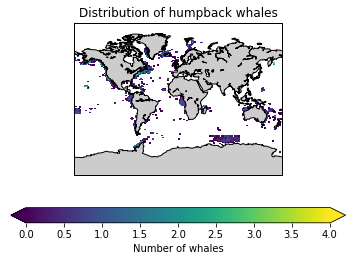

In [36]:
plt.figure(figsize=(1000,1000))
plt.show()


In [34]:
plt.show()